In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_1_singlegrid_half'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 3e-6,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.1,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[150,100,80], log_std_init=-2.9),
                verbose = 1,
                target_kl = 0.05,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

Using cuda device
seed 1: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fe01d2c2390> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fe01d2b5390>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.59 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.594    |
| time/              |          |
|    fps             | 155      |
|    iterations      | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 39 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.598       |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| t

policy iteration runtime: 37 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.618       |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010554666 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.784       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0627      |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.027      |
|    std                  | 

policy iteration runtime: 42 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.645       |
| time/                   |             |
|    fps                  | 167         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009105894 |
|    clip_fraction        | 0.339       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.83        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0677      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0271     |
|    std                  | 

policy iteration runtime: 38 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.659        |
| time/                   |              |
|    fps                  | 168          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0050147446 |
|    clip_fraction        | 0.346        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.864        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0687       |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.0281      |
|    std

policy iteration runtime: 39 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.667       |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007847264 |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.873       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0452      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.674        |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0049529015 |
|    clip_fraction        | 0.341        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.881        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0641       |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.0287      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 167         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008797228 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.894       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.056       |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0288     |
|    std                  |

policy iteration runtime: 35 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.685        |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056047114 |
|    clip_fraction        | 0.375        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.889        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0319       |
|    n_updates            | 1140         |
|    policy_gradient_loss | -0.0313      |
|    std

policy iteration runtime: 36 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 169          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0067436337 |
|    clip_fraction        | 0.364        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.897        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0719       |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.0298      |
|    std                  | 0.

policy iteration runtime: 36 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.687      |
| time/                   |            |
|    fps                  | 165        |
|    iterations           | 1          |
|    time_elapsed         | 15         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00449155 |
|    clip_fraction        | 0.366      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.908      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0573     |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0296    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 41 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 169         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008302296 |
|    clip_fraction        | 0.345       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.906       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0566      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0283     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010451761 |
|    clip_fraction        | 0.369       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.909       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.034       |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.0311     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 38 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.688        |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0050486354 |
|    clip_fraction        | 0.384        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.9          |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0394       |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.0305      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.689       |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011815962 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.909       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0677      |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0303     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 36 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.689       |
| time/                   |             |
|    fps                  | 170         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009032726 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.901       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0532      |
|    n_updates            | 2260        |
|    policy_gradient_loss | -0.0279     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.69        |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008233341 |
|    clip_fraction        | 0.371       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0415      |
|    n_updates            | 2420        |
|    policy_gradient_loss | -0.0293     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.69        |
| time/                   |             |
|    fps                  | 167         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004904789 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.907       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0814      |
|    n_updates            | 2580        |
|    policy_gradient_loss | -0.029      |
|    std                  |

policy iteration runtime: 42 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.689       |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007346821 |
|    clip_fraction        | 0.378       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.913       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0408      |
|    n_updates            | 2740        |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.0549      |
|    va

policy iteration runtime: 36 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.69       |
| time/                   |            |
|    fps                  | 167        |
|    iterations           | 1          |
|    time_elapsed         | 15         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00780427 |
|    clip_fraction        | 0.37       |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.9       |
|    explained_variance   | 0.909      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0753     |
|    n_updates            | 2900       |
|    policy_gradient_loss | -0.0292    |
|    std                  | 0.0549     |
|    value_loss           |

<IPython.core.display.Javascript object>


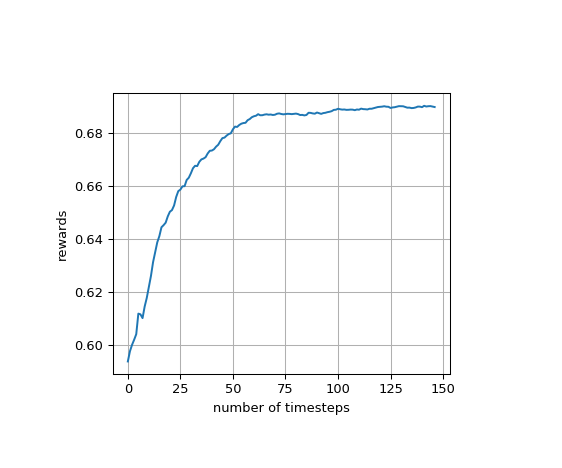

Using cuda device
seed 2: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fe0a9644c88> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fdfc41cbb00>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.599        |
| time/                   |              |
|    fps                  | 153          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056955516 |
|    clip_fraction        | 0.375        |
|    clip_range           | 0.1          |
|    entropy_loss         | 92           |
|    explained_variance   | 0.909        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0546       |
|    n_updates            | 2940         |
|    policy_gradient_loss | -0.0284      |
|    std                  | 0.0549       |
|    value_loss           | 0.0031

policy iteration runtime: 42 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.622       |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.014155095 |
|    clip_fraction        | 0.331       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.793       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0533      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0263     |
|    std                  | 

policy iteration runtime: 40 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.644      |
| time/                   |            |
|    fps                  | 164        |
|    iterations           | 1          |
|    time_elapsed         | 15         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00782196 |
|    clip_fraction        | 0.348      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.844      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.072      |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0277    |
|    std                  | 0.055      |
|    v

policy iteration runtime: 38 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.665       |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009256092 |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.856       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0694      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0268     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.672       |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004264629 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.87        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0578      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0289     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.678        |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0079580275 |
|    clip_fraction        | 0.346        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.887        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0515       |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.0294      |
|    std                  | 0.

policy iteration runtime: 40 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.683        |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075295717 |
|    clip_fraction        | 0.331        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.89         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.108        |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.0276      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0069987504 |
|    clip_fraction        | 0.344        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.89         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0314       |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.0286      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004442832 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.904       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0404      |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.029      |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 45 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.689       |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004542035 |
|    clip_fraction        | 0.362       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.899       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0585      |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0289     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.69        |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006269944 |
|    clip_fraction        | 0.354       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.911       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0577      |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.0297     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.691      |
| time/                   |            |
|    fps                  | 166        |
|    iterations           | 1          |
|    time_elapsed         | 15         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00587464 |
|    clip_fraction        | 0.356      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.914      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0498     |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.0278    |
|    std                  | 0.0551     |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.692       |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008578593 |
|    clip_fraction        | 0.368       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.915       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0625      |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0289     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.692       |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008962834 |
|    clip_fraction        | 0.371       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0569      |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0293     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.692        |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0077198297 |
|    clip_fraction        | 0.359        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.916        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0758       |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.028       |
|    std                  | 0.

policy iteration runtime: 45 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.692       |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008388477 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.914       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.044       |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 39 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.692       |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.003883162 |
|    clip_fraction        | 0.368       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.918       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0923      |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.0265     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.692       |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007713559 |
|    clip_fraction        | 0.384       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.918       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0687      |
|    n_updates            | 2720        |
|    policy_gradient_loss | -0.0299     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 36 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.691       |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006607893 |
|    clip_fraction        | 0.375       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.92        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0566      |
|    n_updates            | 2880        |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.055       |
|    va

<IPython.core.display.Javascript object>


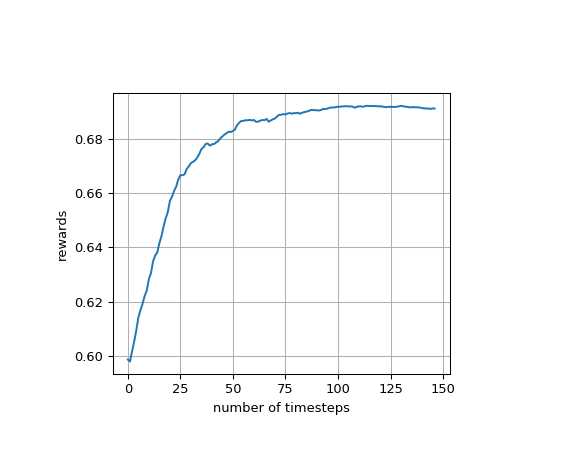

Using cuda device
seed 3: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fe01ef19be0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fdfc4028d68>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.598      |
| time/                   |            |
|    fps                  | 156        |
|    iterations           | 1          |
|    time_elapsed         | 16         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00878156 |
|    clip_fraction        | 0.383      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.923      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0729     |
|    n_updates            | 2940       |
|    policy_gradient_loss | -0.0301    |
|    std                  | 0.055      |
|    value_loss           | 0.00279    |
---------------------------------

policy iteration runtime: 36 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.61 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.614       |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009046296 |
|    clip_fraction        | 0.331       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.783       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0545      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0254     |
|    std                  | 

policy iteration runtime: 37 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.63 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.635        |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056693642 |
|    clip_fraction        | 0.328        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.854        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0392       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0255      |
|    std 

policy iteration runtime: 37 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.653       |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010885393 |
|    clip_fraction        | 0.334       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.869       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0704      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0267     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.668       |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005089405 |
|    clip_fraction        | 0.331       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.885       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0706      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0264     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.675       |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010316816 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.9         |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0546      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0297     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.682        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0073146373 |
|    clip_fraction        | 0.349        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.896        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0468       |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.0287      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006783375 |
|    clip_fraction        | 0.346       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.903       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0607      |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.0274     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 41 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.686       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.002202645 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0687      |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.0289     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004782924 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.907       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0621      |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.029      |
|    std                  |

policy iteration runtime: 41 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0067678364 |
|    clip_fraction        | 0.339        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.906        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0659       |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.0273      |
|    std                  | 0.

policy iteration runtime: 36 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.688        |
| time/                   |              |
|    fps                  | 162          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0068669706 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.913        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0692       |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.0292      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.69         |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0065716268 |
|    clip_fraction        | 0.355        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.914        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0488       |
|    n_updates            | 1920         |
|    policy_gradient_loss | -0.0284      |
|    std                  | 0.

policy iteration runtime: 45 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.69         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0045992597 |
|    clip_fraction        | 0.367        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.92         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0599       |
|    n_updates            | 2080         |
|    policy_gradient_loss | -0.0294      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.691        |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0060405345 |
|    clip_fraction        | 0.358        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.919        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0742       |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.0285      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.691       |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006696117 |
|    clip_fraction        | 0.354       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.919       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0373      |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0274     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 33 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.691       |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005603215 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.923       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0681      |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.0288     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 45 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.691        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0065349163 |
|    clip_fraction        | 0.362        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.929        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0485       |
|    n_updates            | 2720         |
|    policy_gradient_loss | -0.0277      |
|    std                  | 0.

policy iteration runtime: 37 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.692        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0070709335 |
|    clip_fraction        | 0.379        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.922        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0609       |
|    n_updates            | 2880         |
|    policy_gradient_loss | -0.0287      |
|    std                  | 0.

<IPython.core.display.Javascript object>


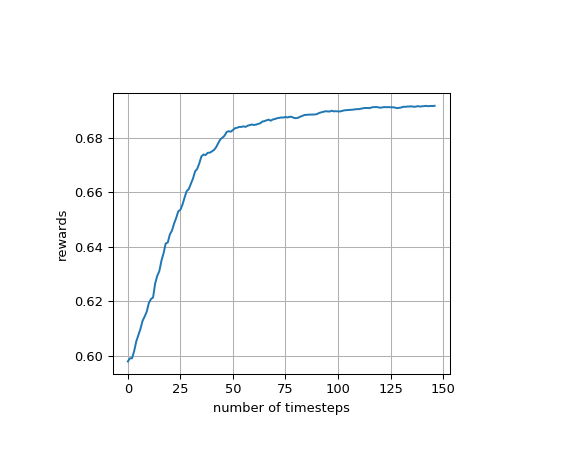

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.5],
                                episode_limit_array=[75000], 
                                log_dir=log_dir,
                                seed=seed)